# Cleaning

In [1]:
# Importing necessary modules
import seaborn as sns
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
from operator import add
from functools import reduce
import numpy as np
import re
import os
from pyspark.sql.types import StructField, StructType, StringType, LongType, FloatType
from pyspark.sql.functions import *
import random
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, StringIndexer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RFormula
import time

# Setting up visualization
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from pyspark.sql.types import FloatType
secondelement=F.udf(lambda v:float(v[1]),FloatType())
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window
import numpy as np


In [2]:
start_time = time.time()

In [3]:
cols_to_keep = [
    "Voters_Gender", # cat
    "Voters_Age", # num
    "Voters_BirthDate", # ignore
    "Residence_Families_HHCount", # num
    "Residence_HHGender_Description", # cat
    "Mailing_Families_HHCount", # num
    "Mailing_HHGender_Description", # cat

#   !! voter party affiliation
    "Parties_Description", 
    
    # cat
    "CommercialData_PropertyType",
    "AddressDistricts_Change_Changed_CD",
    "AddressDistricts_Change_Changed_SD",
    "AddressDistricts_Change_Changed_HD",
    "AddressDistricts_Change_Changed_County",
    
    "Residence_Addresses_Density", # num
    
    # cat
    "CommercialData_EstimatedHHIncome",
    "CommercialData_ISPSA",
    # num
    "CommercialData_AreaMedianEducationYears",
    "CommercialData_AreaMedianHousingValue",
#    "CommercialData_MosaicZ4Global",
    # cat
     "CommercialData_AreaPcntHHMarriedCoupleNoChild",  
     "CommercialData_AreaPcntHHMarriedCoupleWithChild",
     "CommercialData_AreaPcntHHSpanishSpeaking",
     "CommercialData_AreaPcntHHWithChildren",
     "CommercialData_StateIncomeDecile",
#    "Ethnic_Description",
    "EthnicGroups_EthnicGroup1Desc",
    "CommercialData_DwellingType",
    "CommercialData_PresenceOfChildrenCode",
#    "CommercialData_PresenceOfPremCredCrdInHome", ## too many missing
    "CommercialData_DonatesToCharityInHome",
    "CommercialData_DwellingUnitSize",
    "CommercialData_ComputerOwnerInHome",
    "CommercialData_DonatesEnvironmentCauseInHome",
    "CommercialData_Education",
    
#   Don't include because of lookahead bias  
#     "Voters_VotingPerformanceEvenYearGeneral",
#     "Voters_VotingPerformanceEvenYearPrimary",
#     "Voters_VotingPerformanceEvenYearGeneralAndPrimary",
#     "Voters_VotingPerformanceMinorElection",
    
#   Other control variables that expect to be highly associated with outcome:
#     "ElectionReturns_P08CountyTurnoutAllRegisteredVoters",
#     "ElectionReturns_P08CountyTurnoutDemocrats",
#     "ElectionReturns_P08CountyTurnoutRepublicans",
    "General_2000",
    "General_2004",
    "PresidentialPrimary_2000",
    "PresidentialPrimary_2004",
        
#   Outcome variable (indiana law happens in 2005, approved by SCOTUS before presidential election in 2008)
    "General_2008"
]

In [4]:
pct = [
    "CommercialData_AreaPcntHHMarriedCoupleNoChild",  
     "CommercialData_AreaPcntHHMarriedCoupleWithChild",
     "CommercialData_AreaPcntHHSpanishSpeaking",
     "CommercialData_AreaPcntHHWithChildren"
]
    
numeric_cols = [
    'Voters_Age',
    'Residence_Families_HHCount',
    'Mailing_Families_HHCount',
    'Residence_Addresses_Density',
    "CommercialData_AreaMedianEducationYears",
    "CommercialData_AreaMedianHousingValue"
] + pct

trinary_cols = [
    'CommercialData_DonatesToCharityInHome',
    'CommercialData_ComputerOwnerInHome',
    'CommercialData_DonatesEnvironmentCauseInHome'
]

dont_touch_cols = [
    "General_2008", 
    "Voters_BirthDate", 
    "General_2000",
    "General_2004",
    "PresidentialPrimary_2000",
    "PresidentialPrimary_2004"
]

cols_excluded_from_regression = [
    'STATE',
    'General_2008'
]

categorical_cols = [c for c in cols_to_keep if c not in (dont_touch_cols+numeric_cols+cols_excluded_from_regression)]
#other_cols = [c for c in other_cols if c not in (numeric_cols + trinary_cols)]

In [5]:
# These are the states that do not have strict voter ID laws:
#  'VM2Uniform--CA--2021-05-02',	VM2Uniform--CA--2021-05-02	CA	x	California
#  'VM2Uniform--IL--2021-03-05',	VM2Uniform--IL--2021-03-05	IL	x	Illinois
#  'VM2Uniform--MA--2021-01-19',	VM2Uniform--MA--2021-01-19	MA	x	Massachusetts
#  'VM2Uniform--MD--2021-02-15',	VM2Uniform--MD--2021-02-15	MD	x	Maryland
#  'VM2Uniform--ME--2021-05-28',	VM2Uniform--ME--2021-05-28	ME	x	Maine
#  'VM2Uniform--MN--2021-02-14',	VM2Uniform--MN--2021-02-14	MN	x	Minnesota
#  'VM2Uniform--NC--2021-05-18',	VM2Uniform--NC--2021-05-18	NC	x	North Carolina
#  'VM2Uniform--NE--2021-01-20',	VM2Uniform--NE--2021-01-20	NE	x	Nebraska
#  'VM2Uniform--NJ--2021-03-11',	VM2Uniform--NJ--2021-03-11	NJ	x	New Jersey
#  'VM2Uniform--NM--2021-02-25',	VM2Uniform--NM--2021-02-25	NM	x	New Mexico
#  'VM2Uniform--NV--2021-06-13',	VM2Uniform--NV--2021-06-13	NV	x	Nevada
#  'VM2Uniform--NY--2021-03-15',	VM2Uniform--NY--2021-03-15	NY	x	New York
#  'VM2Uniform--OR--2021-02-05',	VM2Uniform--OR--2021-02-05	OR	x	Oregon
#  'VM2Uniform--PA--2021-05-20',	VM2Uniform--PA--2021-05-20	PA	x	Pennsylvania
#  'VM2Uniform--VT--2021-05-28',	VM2Uniform--VT--2021-05-28	VT	x	Vermont

# For each of these states, I want to pull enough samples to get a total sample of 1/2 M; can increase later

# grab files
states =  [
# For now, just exclude New York and Califonria, because the parquet files take too long to read
'VM2Uniform--VT--2021-05-28', 
'VM2Uniform--IL--2021-03-05',
'VM2Uniform--MA--2021-01-19',
'VM2Uniform--MD--2021-02-15',
'VM2Uniform--ME--2021-05-28',
'VM2Uniform--MN--2021-02-14',
'VM2Uniform--NC--2021-05-18',
'VM2Uniform--NE--2021-01-20',
'VM2Uniform--NJ--2021-03-11',
'VM2Uniform--NM--2021-02-25',
'VM2Uniform--NV--2021-06-13',
'VM2Uniform--OR--2021-02-05',
'VM2Uniform--PA--2021-05-20',
'VM2Uniform--CA--2021-05-02',
'VM2Uniform--NY--2021-03-15',
'VM2Uniform--IN--2021-01-15'
]

# bucket file path for all state parquet files
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'

# create list of state abbreviations
pattern = re.compile(r"(?<=--)[A-Z]{2}")
state_abvs = re.findall(pattern, ''.join(states))

# do first iteration
print('VM2Uniform--VT--2021-05-28')

# num_per_state = 500

df_ref = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--VT--2021-05-28']))
df_ref = df_ref.select(cols_to_keep)

numrows = {'VM2Uniform--VT--2021-05-28': df_ref.count()}

print("%d" % (numrows['VM2Uniform--VT--2021-05-28']))
    
percentage_sample = 0.002 #num_per_state / numrows['VM2Uniform--VT--2021-05-28']
    
df_ref = df_ref.sample(True, percentage_sample, seed = 19480384)
df_ref = df_ref.withColumn('STATE', F.lit(state_abvs[0]))
 
next_states = states[1:]

# do the rest of the iterations
for i, one_state in enumerate(next_states):

    print("%s: " % (one_state), end="")
    
    # read dataframe for one_state
    tmp_ref = spark.read.parquet("/".join([gcs_path, one_state]))
    tmp_ref = tmp_ref.select(cols_to_keep)
    numrows[one_state] = tmp_ref.count()
    print("%d" % (numrows[one_state]))
    
#     percentage_sample = num_per_state / numrows[one_state]
    
    tmp_ref = tmp_ref.sample(True, percentage_sample, seed = 19480384)
    tmp_ref = tmp_ref.withColumn('STATE', F.lit(state_abvs[i+1]))
    
    df_ref = df_ref.union(tmp_ref)      

df_ref.printSchema()
df_ref.count()

VM2Uniform--VT--2021-05-28


463261
VM2Uniform--IL--2021-03-05: 

8336875
VM2Uniform--MA--2021-01-19: 

4572639
VM2Uniform--MD--2021-02-15: 

4110570
VM2Uniform--ME--2021-05-28: 1040452
VM2Uniform--MN--2021-02-14: 

3563623
VM2Uniform--NC--2021-05-18: 

6616158
VM2Uniform--NE--2021-01-20: 

1201308
VM2Uniform--NJ--2021-03-11: 

6109844
VM2Uniform--NM--2021-02-25: 1205712
VM2Uniform--NV--2021-06-13: 

1866442
VM2Uniform--OR--2021-02-05: 

3166785
VM2Uniform--PA--2021-05-20: 

8359764
VM2Uniform--CA--2021-05-02: 

21779518
VM2Uniform--NY--2021-03-15: 

12570650
VM2Uniform--IN--2021-01-15: 

4396576
root
 |-- Voters_Gender: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Voters_BirthDate: string (nullable = true)
 |-- Residence_Families_HHCount: string (nullable = true)
 |-- Residence_HHGender_Description: string (nullable = true)
 |-- Mailing_Families_HHCount: string (nullable = true)
 |-- Mailing_HHGender_Description: string (nullable = true)
 |-- Parties_Description: string (nullable = true)
 |-- CommercialData_PropertyType: string (nullable = true)
 |-- AddressDistricts_Change_Changed_CD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_SD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_HD: string (nullable = true)
 |-- AddressDistricts_Change_Changed_County: string (nullable = true)
 |-- Residence_Addresses_Density: string (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- CommercialData_ISPSA: string (nullable = true)
 |-- CommercialData_AreaMedianEducationYears: string (nullable 

176746

In [6]:
# 90 seconds

### FUNCTIONS TO CLEAN DATASET

In [7]:
def clean_voter_participation(input_df: DataFrame) -> DataFrame:

    yrs_add = 18
    months_add = 18*12

    # date of national 
    target_month_day_presidential = "11-03"

    # date of presidential primary (ideally we should do this state by state, but this is the date for Indiana's)
    target_month_day_primary = "05-03" 

    input_df = input_df.withColumn("DATE_18", add_months(to_date(col("Voters_BirthDate"),"MM/dd/yyyy"), months_add))
    input_df.select(["Voters_BirthDate", "DATE_18"]).show(10)
    input_df = input_df.dropna(subset = "Voters_BirthDate")
    input_df = input_df.withColumn("YEAR_18", year("DATE_18"))
    input_df = input_df.withColumn("comparator_date_presidential", to_date(concat(col("YEAR_18"), lit("-"), lit(target_month_day_presidential))))
    input_df = input_df.withColumn("comparator_date_primary", to_date(concat(col("YEAR_18"), lit("-"), lit(target_month_day_primary))))

    for election in ["PRESIDENTIAL", "PRIMARY"]:
        input_df = input_df.withColumn(f"YEAR_ELIGIBLE_TO_VOTE_{election}", \
                                    when(col("DATE_18")<=col(f"comparator_date_{election.lower()}"), col("YEAR_18")) \
                                   .otherwise(col("YEAR_18") + 1) \
                                  )

    # check no missing vals:
    input_df.where(col("YEAR_18").isNull()).select("YEAR_18").show(10)

    # get rid of rows where the voter was not old enough to vote in the 2008 general election
    input_df = input_df.filter(col("YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL")<=2008).fillna("N", subset = ["General_2008"])

    # for the 2000 and 2004 general elections, replace with "N" IF the person was old enough to vote at the time

    for election in ["2000", "2004"]:
        input_df = input_df.withColumn(f"General_{election}", \
                                   when((col("YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL")<= int(election)) & \
                                        (col(f"General_{election}").isNull()), "N") \
                                   .otherwise(col(f"General_{election}")) \
                                  )

        input_df = input_df.withColumn(f"PresidentialPrimary_{election}", \
                                   when((col("YEAR_ELIGIBLE_TO_VOTE_PRIMARY")<= int(election)) & \
                                        (col(f"PresidentialPrimary_{election}").isNull()), "N") \
                                   .otherwise(col(f"PresidentialPrimary_{election}")) \
                                  )

    # make the general voting for 2008 a numeric variable; since we've deleted
    # everyone who was not eligible to vote, this can be directly calculated with a 1-0.
    input_df = input_df.withColumn("Voted_General_2008", when(input_df.General_2008 == "Y",1).otherwise(0))
    input_df = input_df.withColumn("General_2008", F.col("Voted_General_2008"))
    
    elec_cols = ["General_2000", "General_2004", "PresidentialPrimary_2000", "PresidentialPrimary_2004"]
    input_df = input_df.fillna("Unknown", subset=elec_cols)
    
    to_drop = [
        'Voters_BirthDate', # removed this, but KEPT the YEAR that the voter turned 18.
        'DATE_18',
        'YEAR_18',
        'comparator_date_presidential',
        'comparator_date_primary',
        'YEAR_ELIGIBLE_TO_VOTE_PRESIDENTIAL',
        'YEAR_ELIGIBLE_TO_VOTE_PRIMARY',
        'Voted_General_2008'
    ]
    input_df = input_df.drop(*to_drop)
    
    return input_df

In [8]:
def clean_numeric_categorical(input_df: DataFrame) -> DataFrame:
    
    # remove special symbols ($, %) from relevant columns
    input_df = input_df.withColumn(
        "CommercialData_AreaMedianHousingValue",
        F.expr("substring(CommercialData_AreaMedianHousingValue, 2, length(CommercialData_AreaMedianHousingValue))"))

    for c in pct:
        input_df = input_df.withColumn(
            c,
            F.expr(f"substring({c}, 1, length({c})-1)")
        )
    input_df.select(["CommercialData_AreaMedianHousingValue"]+pct).show()


    for c in numeric_cols:
        input_df = input_df.withColumn(c, F.col(c).cast("float").alias(c))
#     input_df = input_df.fillna("U", subset= trinary_cols)
#     input_df = input_df.fillna("Missing", subset = other_cols)
#   input_df = input_df.fillna("N", subset = binary_cols)
    
    return input_df

In [9]:
def impute_numeric_values_function(input_df: DataFrame) -> DataFrame:

    # Create copy of working df
    input_df = input_df.alias('input_df')
    
    # Impute the missing values in the numerical columns with the mean -- minimize change to z-scores of given data
    imputer = Imputer(
        inputCols=numeric_cols, 
        outputCols=numeric_cols
    )

    input_df = imputer.fit(input_df).transform(input_df)
    
    return input_df

In [10]:
def impute_categorical_values_function(input_df: DataFrame) -> DataFrame:

    # Create copy of working df
    input_df = input_df.alias('input_df')
    
    input_df = input_df.withColumn("CommercialData_ISPSA", F.col("CommercialData_ISPSA").cast('string'))
    input_df = input_df.withColumn("CommercialData_StateIncomeDecile",
                                   F.col("CommercialData_StateIncomeDecile").cast('string'))
    
    input_df = input_df.fillna("U", subset= trinary_cols)
    input_df = input_df.fillna("Unknown", subset = categorical_cols)
    
    return input_df

In [11]:
# indi = spark.read.parquet("gs://voter-project-235-25/VM2Uniform--IN--2021-01-15_parq")
# indi = indi.sample(True, 0.1, seed = 19480384)
# indi = indi.select(cols_to_keep)
#indi = indi.withColumn("STATE", lit("IN"))

In [12]:
# indi = clean_voter_participation(indi)
# indi = clean_numeric_categorical(indi)
# indi = impute_numeric_values_function(indi)
# indi = impute_categorical_values_function(indi)
# indi.printSchema()

In [13]:
df_ref = clean_voter_participation(df_ref)
df_ref = clean_numeric_categorical(df_ref)
df_ref = impute_numeric_values_function(df_ref)
df_ref = impute_categorical_values_function(df_ref)
df_ref.printSchema()

+----------------+----------+
|Voters_BirthDate|   DATE_18|
+----------------+----------+
|      01/01/1994|2012-01-01|
|      06/24/1991|2009-06-24|
|      08/01/1969|1987-08-01|
|      01/01/1982|2000-01-01|
|      01/01/1956|1974-01-01|
|      04/01/1945|1963-04-01|
|      06/01/1964|1982-06-01|
|      01/01/2000|2018-01-01|
|      08/16/1949|1967-08-16|
|      03/14/1961|1979-03-14|
+----------------+----------+
only showing top 10 rows



+-------+
|YEAR_18|
+-------+
+-------+

+-------------------------------------+---------------------------------------------+-----------------------------------------------+----------------------------------------+-------------------------------------+
|CommercialData_AreaMedianHousingValue|CommercialData_AreaPcntHHMarriedCoupleNoChild|CommercialData_AreaPcntHHMarriedCoupleWithChild|CommercialData_AreaPcntHHSpanishSpeaking|CommercialData_AreaPcntHHWithChildren|
+-------------------------------------+---------------------------------------------+-----------------------------------------------+----------------------------------------+-------------------------------------+
|                               263042|                                           32|                                             16|                                       1|                                   23|
|                               222916|                                           35|                      

root
 |-- Voters_Gender: string (nullable = false)
 |-- Voters_Age: float (nullable = true)
 |-- Residence_Families_HHCount: float (nullable = true)
 |-- Residence_HHGender_Description: string (nullable = false)
 |-- Mailing_Families_HHCount: float (nullable = true)
 |-- Mailing_HHGender_Description: string (nullable = false)
 |-- Parties_Description: string (nullable = false)
 |-- CommercialData_PropertyType: string (nullable = false)
 |-- AddressDistricts_Change_Changed_CD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_SD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_HD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_County: string (nullable = false)
 |-- Residence_Addresses_Density: float (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = false)
 |-- CommercialData_ISPSA: string (nullable = false)
 |-- CommercialData_AreaMedianEducationYears: float (nullable = true)
 |-- CommercialData_AreaMedianHousingValue

In [14]:
df_ref.cache()
df_ref.count()

# 104.09 seconds

23/03/23 02:59:34 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/03/23 02:59:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1691.3 KiB


141559

In [15]:
end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))
print("Start time: {:.2f}".format(start_time))
print("End time: {:.2f}".format(end_time))

Execution time: 205.24 seconds
Start time: 1679540210.14
End time: 1679540415.38


# Estimator with logistic regression index model

In [16]:
start_time = time.time()

In [17]:
from pyspark.ml.feature import RFormula
supervised = RFormula(formula="General_2008 ~ . - STATE")

new_df = (
    df_ref.alias('new_df')
    #.select([c for c in df_ref.columns if c != 'STATE'])
    .withColumn('General_2008', F.col('General_2008').cast('float').alias('General_2008'))
)

fittedRF = supervised.fit(new_df)

preparedDF = fittedRF.transform(new_df)

preparedDF.select("features").show(n=10, truncate = False)

indi = preparedDF.filter(F.col('STATE') == 'IN') 
not_indi = preparedDF.filter(F.col('STATE') != 'IN') 

23/03/23 03:00:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1694.0 KiB
23/03/23 03:00:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1697.0 KiB
23/03/23 03:00:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1694.0 KiB
23/03/23 03:00:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1697.0 KiB
23/03/23 03:00:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1694.0 KiB
23/03/23 03:00:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1697.0 KiB
23/03/23 03:00:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1694.0 KiB
23/03/23 03:00:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1697.0 KiB
23/03/23 03:00:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(135,[0,2,3,4,7,8,11,

In [ ]:
train, test = not_indi.randomSplit([0.7, 0.3], seed = 42069)
train.count()

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()

lrModel = lr.fit(train)

featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

plt.rcParams["figure.figsize"] = (8,6)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

In [ ]:
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
cols = ['coefs']
coefsDF[cols] = coefsDF[coefsDF[cols].abs() > 0.25][cols]
coefsDF.dropna(inplace = True)
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

plt.rcParams["figure.figsize"] = (20,5)

plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

In [ ]:
summary = lrModel.summary
print(summary.areaUnderROC)

In [ ]:
fittedTest = lrModel.transform(test)
fittedTest.groupBy("label", "prediction").count().show()

In [ ]:
fittedTest.select("label","prediction","rawPrediction").show(n=10)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
aucEvaluator = BinaryClassificationEvaluator()
print(aucEvaluator.evaluate(fittedTest,{aucEvaluator.metricName: "areaUnderROC"}))

In [ ]:
indi.select("features").show(n=10, truncate = False)

In [ ]:
fittedTest_indi = lrModel.transform(indi)
fittedTest_indi.groupBy("label", "prediction").count().show()

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
aucEvaluator = BinaryClassificationEvaluator()
print(aucEvaluator.evaluate(fittedTest_indi,{aucEvaluator.metricName: "areaUnderROC"}))

In [ ]:
end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))
print("Start time: {:.2f}".format(start_time))
print("End time: {:.2f}".format(end_time))

# Doubly Robust Estimator / Propensity Score Estimator

In [18]:
from pyspark.ml.classification import LogisticRegression

# empty list to store the estimated average treatment effects:
# propensity score:
ATE_PS = []
# doubly robust:
ATE_DR = []

start_time = time.time()

In [19]:
# get a balanced sample for the treatment and control: right now we have WAY more control than treated, so 
# we end up defaulting to low probabilities in the logistic regression:

# create a dataframe for Indiana, and one for the other states. We are going to 
# bootstrap sample the other states to have the same sample as that of Indiana

num_voters_indiana = indi.count()
num_voters_not_indiana = not_indi.count()
pct_sample = num_voters_indiana / num_voters_not_indiana

# take random sample of the total parquet file (equivalent to the size of indiana)
not_indi_sampled = not_indi.sample(True, pct_sample, seed = i)

# union the two together
preparedDF_sampled = not_indi_sampled.union(indi)

23/03/23 03:01:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1693.1 KiB
23/03/23 03:01:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1692.2 KiB


In [20]:
lr = LogisticRegression()
# preparedDF from first LR model -- has features of all variables except General_2008 and STATE
#train, test = preparedDF.randomSplit([0.7, 0.3], seed = 42069)
# lrModel from other section, trained on other state data, predict on other state + indiana
mu0model = lr.fit(not_indi_sampled).transform(preparedDF_sampled)
mu0 = mu0model.select("probability")
# train the model on indiana data, predict on other state + indiana
mu1model = lr.fit(indi).transform(preparedDF_sampled)
mu1 = mu1model.select("probability")
# Currently, the label column is General_2008. We now want to predict whether the law was passed (State == Indiana).
# Thus, change label column from General_2008 data to Treatment indicator.
train_new = preparedDF_sampled.drop("label")
train_new = train_new.withColumn('label', F.when(F.col('STATE') == 'IN', 1.0).otherwise(0.0))
# train model on other state + indiana, predict on other state + indiana
psmodel = lr.fit(train_new).transform(train_new)
ps = psmodel.select("probability")

23/03/23 03:01:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1958.1 KiB
23/03/23 03:01:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1959.3 KiB
23/03/23 03:01:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1959.5 KiB
23/03/23 03:01:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1960.6 KiB
23/03/23 03:01:49 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/23 03:01:49 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/03/23 03:01:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1959.5 KiB
23/03/23 03:01:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1960.6 KiB
23/03/23 03:01:51 WARN org.apache.spark.sch

In [21]:
# since there is no common column between these two dataframes add row_index so that it can be joined
train_new=train_new.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
mu1=mu1.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))\
.withColumnRenamed('probability', 'mu1')
mu0=mu0.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))\
.withColumnRenamed('probability', 'mu0')
ps=ps.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))\
.withColumnRenamed('probability', 'ps')

In [22]:
train_new = train_new.join(mu1, on=["row_index"])\
.join(mu0, on=["row_index"])\
.join(ps, on=["row_index"])\
.drop("row_index")

In [23]:
train_new.select("mu0", "mu1", "ps", "label", "General_2008").show(10, truncate = False)

23/03/23 03:11:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:11:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:11:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:11:11 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:11:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1700.5 KiB
23/03/23 03:11:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

+-----------------------------------------+----------------------------------------+----------------------------------------+-----+------------+
|mu0                                      |mu1                                     |ps                                      |label|General_2008|
+-----------------------------------------+----------------------------------------+----------------------------------------+-----+------------+
|[0.04554160571746415,0.9544583942825359] |[0.06466888365371595,0.9353311163462841]|[0.813459146851629,0.186540853148371]   |0.0  |1.0         |
|[0.4889579991334586,0.5110420008665414]  |[0.1922965573186995,0.8077034426813006] |[0.5929549667894871,0.4070450332105129] |0.0  |0.0         |
|[0.044157434287835584,0.9558425657121644]|[0.05343021543828552,0.9465697845617145]|[0.9297717556332363,0.07022824436676367]|0.0  |1.0         |
|[0.7308311042699348,0.2691688957300652]  |[0.7553771663918317,0.24462283360816828]|[0.4069320106627668,0.5930679893372333] |0.0  

In [24]:
train_new = train_new.withColumn("mu0", secondelement("mu0"))
train_new = train_new.withColumn("mu1", secondelement("mu1"))
train_new = train_new.withColumn("ps", secondelement("ps"))

train_new.select("mu0", "mu1", "ps", "label", "General_2008").show(truncate = False)

23/03/23 03:11:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:11:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:11:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:11:45 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:11:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1700.5 KiB
23/03/23 03:11:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

+-----------+-----------+-----------+-----+------------+
|mu0        |mu1        |ps         |label|General_2008|
+-----------+-----------+-----------+-----+------------+
|0.9544584  |0.9353311  |0.18654086 |0.0  |1.0         |
|0.511042   |0.80770344 |0.40704504 |0.0  |0.0         |
|0.95584255 |0.9465698  |0.07022824 |0.0  |1.0         |
|0.26916888 |0.24462283 |0.593068   |0.0  |0.0         |
|0.080391794|0.11230392 |0.36985034 |0.0  |0.0         |
|0.8670447  |0.88830954 |0.0734897  |0.0  |1.0         |
|0.92045885 |0.92220634 |0.4116301  |0.0  |1.0         |
|0.28837994 |0.7083873  |0.23591422 |0.0  |0.0         |
|0.28837994 |0.7083873  |0.23591422 |0.0  |0.0         |
|0.97276616 |0.9501314  |0.41000167 |0.0  |1.0         |
|0.15637256 |0.24586579 |0.38419792 |0.0  |0.0         |
|0.9691453  |0.97627145 |0.5393557  |0.0  |1.0         |
|0.9824213  |0.97872657 |0.008350597|0.0  |1.0         |
|0.9824213  |0.97872657 |0.008350597|0.0  |1.0         |
|0.3060047  |0.20873281 |0.1708

In [25]:
train_new = train_new.withColumnRenamed("General_2008", "Y")
train_new = train_new.withColumnRenamed("label", "T")

In [26]:
train_new.printSchema()

root
 |-- Voters_Gender: string (nullable = false)
 |-- Voters_Age: float (nullable = true)
 |-- Residence_Families_HHCount: float (nullable = true)
 |-- Residence_HHGender_Description: string (nullable = false)
 |-- Mailing_Families_HHCount: float (nullable = true)
 |-- Mailing_HHGender_Description: string (nullable = false)
 |-- Parties_Description: string (nullable = false)
 |-- CommercialData_PropertyType: string (nullable = false)
 |-- AddressDistricts_Change_Changed_CD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_SD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_HD: string (nullable = false)
 |-- AddressDistricts_Change_Changed_County: string (nullable = false)
 |-- Residence_Addresses_Density: float (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = false)
 |-- CommercialData_ISPSA: string (nullable = false)
 |-- CommercialData_AreaMedianEducationYears: float (nullable = true)
 |-- CommercialData_AreaMedianHousingValue

In [27]:
# calculate propensity score ATE:-------

# new column that called weight that is T - PS / (PS * 1 - PS)
train_new = train_new.withColumn('ps', col('ps').cast('double'))
train_new = train_new.withColumn("weight", (F.col("T") - F.col("ps")) / (F.col("ps") * (1-F.col("ps"))))

# calculate the weighted average
train_new = train_new.withColumn("weighted_outcome", F.col("Y") * F.col("weight"))

# store weighted average into list
ATE_PS_this_round = train_new.agg(avg(col("weighted_outcome"))).collect()[0][0]

print(ATE_PS_this_round)
ATE_PS.append(ATE_PS_this_round)

23/03/23 03:12:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:12:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:12:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:12:16 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:12:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1700.5 KiB
23/03/23 03:12:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

2.1771475989627134


In [28]:
# calculate doubly robust ATE:-------

tmp = train_new.select(
    F.expr("mean(T * (Y -mu1)/ps + mu1)").alias("first_term"),
    F.expr("mean((1-T) * (Y - mu0)/(1-ps) + mu0)").alias("second_term")
)

tmp = tmp.withColumn("doubly_robust", F.col('first_term') - F.col('second_term'))
ATE_DR_this_round = tmp.toPandas()['doubly_robust'].to_numpy()[0]
print("Doubly Robust ATE: {:.2f}".format(ATE_DR_this_round))
ATE_DR.append(ATE_DR_this_round)

end_time = time.time()

23/03/23 03:12:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:12:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:12:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:12:40 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:12:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1700.5 KiB
23/03/23 03:12:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

Doubly Robust ATE: 0.05


In [29]:
print("ATE_PS : ", ATE_PS)
print("0.05th quantile of ATE_PS : ", np.quantile(ATE_PS, .05))
print("0.95th quantile of ATE_PS : ", np.quantile(ATE_PS, .95))

ATE_PS :  [2.1771475989627134]
0.05th quantile of ATE_PS :  2.1771475989627134
0.95th quantile of ATE_PS :  2.1771475989627134


In [30]:
print("ATE_DR : ", ATE_DR)
print("0.05th quantile of ATE_DR : ", np.quantile(ATE_DR, .05))
print("0.95th quantile of ATE_DR : ", np.quantile(ATE_DR, .95))

ATE_DR :  [0.04703879173449099]
0.05th quantile of ATE_DR :  0.04703879173449099
0.95th quantile of ATE_DR :  0.04703879173449099


# PLOTS TO CHECK

23/03/23 03:13:09 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:13:09 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:13:09 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:13:09 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/23 03:13:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1699.7 KiB
23/03/23 03:13:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

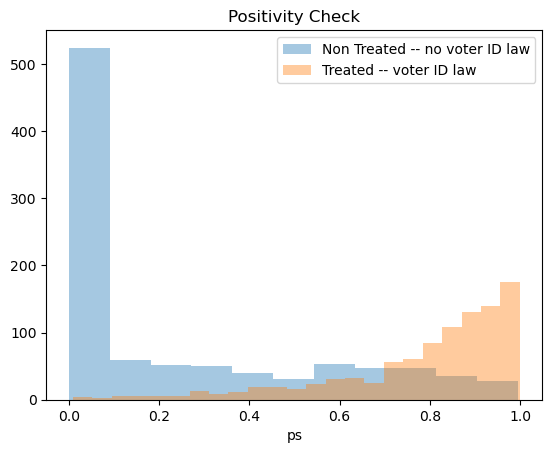

In [31]:
# plot the propensity score across STATES

df_plot = train_new.select('T', 'ps', 'STATE').sample(True, 0.14, seed = i).toPandas()
sns.distplot(df_plot.query("T==0")["ps"], kde=False, label="Non Treated -- no voter ID law")
sns.distplot(df_plot.query("T==1")["ps"], kde=False, label="Treated -- voter ID law")
plt.title("Positivity Check")
plt.legend();

23/03/23 03:13:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


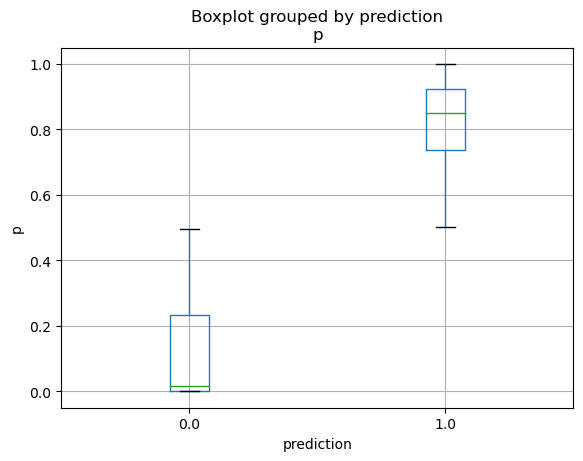

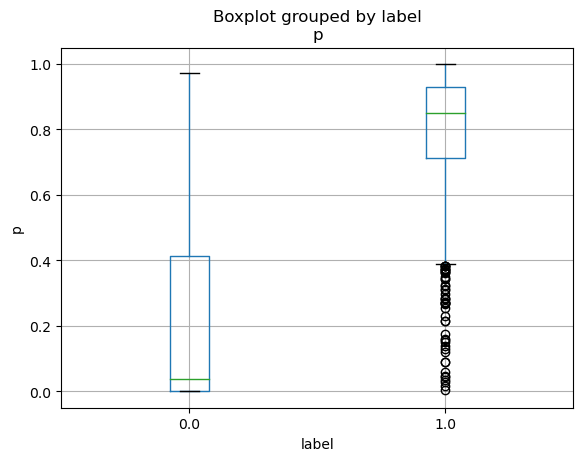

In [32]:
# Check that we have the right propensity score:

CHECK = psmodel.select(["probability", "prediction", "label"])
CHECK = CHECK.withColumn("p", secondelement("probability"))
CHECK = CHECK.sample(True, 0.1, seed = i).toPandas()
CHECK.head()

# boxplots
import matplotlib.pyplot as plt
CHECK.boxplot(column='p', by='prediction')
plt.xlabel('prediction')
plt.ylabel('p')
plt.show()

CHECK.boxplot(column='p', by='label')
plt.xlabel('label')
plt.ylabel('p')
plt.show()